<a href="https://colab.research.google.com/github/sarahgruetz/AluraChallenge_DS_2/blob/main/modelo_regressao.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup do Spark

In [1]:
# instalar as dependências
!apt-get update -qq 
!apt-get install openjdk-8-jdk-headless -qq > /dev/null # instalando java 
!wget -q https://archive.apache.org/dist/spark/spark-3.1.2/spark-3.1.2-bin-hadoop2.7.tgz # baixando spark
!tar xf spark-3.1.2-bin-hadoop2.7.tgz # descompactando
!pip install -q findspark # instalando

In [2]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.2-bin-hadoop2.7"

In [3]:
import findspark
findspark.init()

### Criando a SparkSession

In [5]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .appName("Modelo de regressão") \
    .getOrCreate()

### Carregando e visualizando o dataset

Dataset já com as transformações e filtros realizados na semana 1.

In [6]:
import zipfile

zipfile.ZipFile('/content/drive/MyDrive/curso-spark/ChallengeAlura/semana-2.zip','r')\
        .extractall('/content/drive/MyDrive/curso-spark/ChallengeAlura/dados')

In [7]:
dataset = spark.read.parquet('/content/drive/MyDrive/curso-spark/ChallengeAlura/dados/dataset_transformado_parquet')

In [8]:
dataset.show(5)

+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|                  id|andar|area_total|area_util|banheiros|     caracteristicas|quartos|suites|tipo_anuncio|tipo_unidade|   tipo_uso|vaga|      bairro|        zona|condominio|iptu| tipo| valor|
+--------------------+-----+----------+---------+---------+--------------------+-------+------+------------+------------+-----------+----+------------+------------+----------+----+-----+------+
|03a386b6-7ab8-4ef...|    0|        43|       43|        1|[Churrasqueira, A...|      2|  null|       Usado| Apartamento|Residencial|   1|    Realengo|  Zona Oeste|       285|null|Venda| 22999|
|1fe78d41-b8e0-4d2...|    0|        44|       44|        1|                  []|      2|     0|       Usado| Apartamento|Residencial|   0|       Irajá|  Zona Norte|       170|   0|Venda|110000|
|1fa1c1e5-e98c-433...|    4|  

In [9]:
dataset.count()

66562

### Seleção de Features

Selecionando as variáveis que serão utilizadas no modelo. Importante para redução da complexidade.

As colunas `tipo_anuncio`, `tipo_unidade`, `tipo_uso` e `tipo` foram filtradas na semana 1 e devem conter apenas um valor. Confirmando isso:

In [10]:
valor_unico = ['tipo_anuncio','tipo_unidade','tipo_uso','tipo']
for c in valor_unico:
  dataset\
    .select(c)\
    .groupBy(c)\
    .count()\
    .show()

+------------+-----+
|tipo_anuncio|count|
+------------+-----+
|       Usado|66562|
+------------+-----+

+------------+-----+
|tipo_unidade|count|
+------------+-----+
| Apartamento|66562|
+------------+-----+

+-----------+-----+
|   tipo_uso|count|
+-----------+-----+
|Residencial|66562|
+-----------+-----+

+-----+-----+
| tipo|count|
+-----+-----+
|Venda|66562|
+-----+-----+



As variáveis `area_total` e `area_util` parecem ter muitos valores iguais.

In [11]:
from pyspark.sql import functions as f

Analisando quantos registros dos 66562 são iguais nas duas colunas.

In [12]:
dataset\
  .select(f.count(f.when(dataset.area_total == dataset.area_util, True)).alias('mesmo_valor') )\
  .show()

+-----------+
|mesmo_valor|
+-----------+
|      55384|
+-----------+



In [13]:
print(f'Cerca de {round((55384/66562)*100,2)} % dos dados são iguais nas duas colunas.')

Cerca de 83.21 % dos dados são iguais nas duas colunas.


55384 dos 66562 registros são iguais nas duas colunas (mais de 83%).

Verificando quantos dados faltantes cada coluna possui.

In [14]:
dataset\
  .select(f.count(f.when(f.isnan('area_total') | f.isnull('area_total'), True)).alias('area_total') )\
  .show()

+----------+
|area_total|
+----------+
|      9194|
+----------+



In [15]:
dataset\
  .select(f.count(f.when(f.isnan('area_util') | f.isnull('area_util'), True)).alias('area_util') )\
  .show()

+---------+
|area_util|
+---------+
|        0|
+---------+



A coluna `area_total` tem mais de 9 mil dados faltantes, enquanto a coluna `area_util` não tem nenhum.

In [16]:
print(f'Apenas {66562 - 55384 - 9194} registros ({round(((66562 - 55384 - 9194)/66562)*100,2)} %) são diferentes entre as duas colunas.') # total registros - registros iguais - registros nulos

Apenas 1984 registros (2.98 %) são diferentes entre as duas colunas.


Analisando a quantidade de valores distintos na coluna `bairro` e a quantidade de registros para cada um dos valores

In [17]:
dataset\
    .select('bairro')\
    .distinct()\
    .count()

154

Top 5 bairros com mais registros

In [18]:
dataset\
  .select('bairro')\
  .groupBy('bairro')\
  .count()\
  .orderBy('count', ascending=False)\
  .show(5)

+--------------------+-----+
|              bairro|count|
+--------------------+-----+
|     Barra da Tijuca|12788|
|Recreio dos Bande...| 7793|
|          Copacabana| 6784|
|         Jacarepaguá| 4437|
|              Tijuca| 3638|
+--------------------+-----+
only showing top 5 rows



Top 5 bairros com menos registros

In [19]:
dataset\
  .select('bairro')\
  .groupBy('bairro')\
  .count()\
  .orderBy('count')\
  .show(10)

+----------------+-----+
|          bairro|count|
+----------------+-----+
|            Caju|    1|
|   Vasco da Gama|    1|
|         Deodoro|    1|
|    Barros Filho|    1|
|Engenho do Porto|    1|
|      Grande Rio|    1|
|Parque da Matriz|    1|
|      Manguinhos|    1|
|          Galeão|    1|
| Parque Anchieta|    2|
+----------------+-----+
only showing top 10 rows



#### Conclusões

Colunas que serão removidas:

`tipo_anuncio`, `tipo_unidade`, `tipo_uso`, `tipo` -> colunas que foram filtradas anteriormente e possuem apenas um registro distinto cada.

`area_total` -> as colunas `area_total` e `area_util` quase sempre tem o mesmo valor, porém a coluna `area_total` tem diversos valores faltantes e a coluna `area_util` não tem nenhum.

`bairro`-> a coluna possui uma quantidade muito grande de valores distintos, muitos deles com poucos registros.

In [20]:
dataset = dataset.drop('tipo_anuncio','tipo_unidade','tipo_uso','tipo','area_total', 'bairro')

## Convertendo tipo das colunas

In [21]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: long (nullable = true)
 |-- area_util: string (nullable = true)
 |-- banheiros: long (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: long (nullable = true)
 |-- suites: long (nullable = true)
 |-- vaga: long (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: string (nullable = true)
 |-- iptu: string (nullable = true)
 |-- valor: string (nullable = true)



As colunas `andar`,`banheiros`,`quartos`, `suites` e `vaga` são do tipo `Long` e podem ser convertidadas para tipo `Integer`.

Já as colunas `area_util`,`condominio`,`iptu` e `valor` são do tipo `String` e devem ser convertidadas para tipo `Double`.

In [22]:
from pyspark.sql.types import IntegerType,DoubleType

In [23]:
long2int = ['andar','banheiros','quartos','suites','vaga']
string2double = ['area_util','condominio','iptu','valor']

In [24]:
for c in long2int:
    dataset = dataset.withColumn(c, dataset[c].cast(IntegerType()))

for c in string2double:
    dataset = dataset.withColumn(c, dataset[c].cast(DoubleType()))

In [25]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- caracteristicas: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)



### Arrumando a coluna `caracteristicas`

Essa coluna é composta por `arrays` de `Strings` que da forma como estão apresentadas não vão poder ser utilizadas no modelo.

Primeiro passo: substituir os `arrays` sem elementos por valores nulos. 

In [26]:
from pyspark.sql import functions as f

In [27]:
dataset = dataset.withColumn('caracteristicas',
                   f.when((f.size(f.col('caracteristicas')) == 0), f.lit(None)).otherwise(f.col("caracteristicas")))

In [28]:
dataset.select('caracteristicas').show(5)

+--------------------+
|     caracteristicas|
+--------------------+
|[Churrasqueira, A...|
|                null|
|                null|
|                null|
|                null|
+--------------------+
only showing top 5 rows



Analisando quantos valores distintos existem dentro dos `arrays` dessa coluna.

In [29]:
caracteristicas = dataset.select(f.explode('caracteristicas').alias('caracteristicas')).distinct()
caracteristicas.show()

+------------------+
|   caracteristicas|
+------------------+
|Condomínio fechado|
|        Playground|
| Portão eletrônico|
|           Piscina|
|Animais permitidos|
|      Portaria 24h|
|          Elevador|
|          Academia|
|   Salão de festas|
|     Churrasqueira|
+------------------+



Iterando por cada uma dessas caracteristicas para criar uma nova coluna para cada com valores `booleanos`. 

In [30]:
lista_caracteristicas = list(caracteristicas.toPandas()['caracteristicas'])
lista_caracteristicas

['Condomínio fechado',
 'Playground',
 'Portão eletrônico',
 'Piscina',
 'Animais permitidos',
 'Portaria 24h',
 'Elevador',
 'Academia',
 'Salão de festas',
 'Churrasqueira']

In [31]:
for caract in lista_caracteristicas:
  dataset = dataset.withColumn(caract, f.when(f.array_contains(dataset['caracteristicas'],caract),f.lit(1)).otherwise(f.lit(0)))

In [32]:
dataset.select(lista_caracteristicas).show(5)

+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+
|Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|Elevador|Academia|Salão de festas|Churrasqueira|
+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+
|                 1|         1|                1|      0|                 1|           1|       0|       1|              1|            1|
|                 0|         0|                0|      0|                 0|           0|       0|       0|              0|            0|
|                 0|         0|                0|      0|                 0|           0|       0|       0|              0|            0|
|                 0|         0|                0|      0|                 0|           0|       0|       0|              0|            0|
|                 0|         0|   

In [33]:
dataset = dataset.drop('caracteristicas')

In [34]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = true)
 |-- banheiros: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- zona: string (nullable = true)
 |-- condominio: double (nullable = true)
 |-- iptu: double (nullable = true)
 |-- valor: double (nullable = true)
 |-- Condomínio fechado: integer (nullable = false)
 |-- Playground: integer (nullable = false)
 |-- Portão eletrônico: integer (nullable = false)
 |-- Piscina: integer (nullable = false)
 |-- Animais permitidos: integer (nullable = false)
 |-- Portaria 24h: integer (nullable = false)
 |-- Elevador: integer (nullable = false)
 |-- Academia: integer (nullable = false)
 |-- Salão de festas: integer (nullable = false)
 |-- Churrasqueira: integer (nullable = false)



## Lidando com os valores faltantes

In [35]:
dataset\
  .select([f.count(f.when(f.isnan(c) | f.isnull(c), True)).alias(c) for c in dataset.columns])\
  .show(vertical=True)

-RECORD 0------------------
 id                 | 0    
 andar              | 0    
 area_util          | 0    
 banheiros          | 0    
 quartos            | 0    
 suites             | 5554 
 vaga               | 3017 
 zona               | 0    
 condominio         | 2371 
 iptu               | 7199 
 valor              | 0    
 Condomínio fechado | 0    
 Playground         | 0    
 Portão eletrônico  | 0    
 Piscina            | 0    
 Animais permitidos | 0    
 Portaria 24h       | 0    
 Elevador           | 0    
 Academia           | 0    
 Salão de festas    | 0    
 Churrasqueira      | 0    



As colunas `suites`,`vaga`,`condominio` e `iptu` possuem valores faltantes. Os modelos não conseguem lidar com esse tipo de dado e eles precisam ser substituidos ou removidos.

Para essas quatro colunas faz sentido substituir os valores faltantes por zero.

Preenchendo com zero:

In [36]:
dataset = dataset\
    .select('*')\
    .na\
    .fill(0)

### Arrumando a coluna `zona`



In [37]:
dataset\
  .select('zona')\
  .groupBy('zona')\
  .count()\
  .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
|            |   11|
+------------+-----+



A coluna `zona` possui valores vazios. Vamos remover eles.

In [38]:
dataset = dataset\
              .where(f.col('zona')!='')

In [39]:
dataset\
  .select('zona')\
  .groupBy('zona')\
  .count()\
  .show()

+------------+-----+
|        zona|count|
+------------+-----+
|  Zona Norte|11897|
|  Zona Oeste|32979|
|Zona Central| 1144|
|    Zona Sul|20531|
+------------+-----+



A coluna `zona` é uma variável categorica do tipo `String`.

Vamos criar variáveis dummy para cada uma das categorias.

In [40]:
zona = dataset\
          .groupBy('id')\
          .pivot('zona')\
          .agg(f.lit(1))\
          .na\
          .fill(0)
zona.show()

+--------------------+------------+----------+----------+--------+
|                  id|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+------------+----------+----------+--------+
|4e47e4d4-3326-4eb...|           0|         0|         0|       1|
|02fba6ef-a691-442...|           0|         0|         1|       0|
|fc03c1a9-8bbb-41a...|           0|         1|         0|       0|
|3dd5d200-0a7f-43d...|           0|         0|         0|       1|
|82707939-71bd-40c...|           0|         0|         0|       1|
|ece1e671-cb4d-48a...|           1|         0|         0|       0|
|3521e03b-0815-4aa...|           0|         0|         0|       1|
|03a386b6-7ab8-4ef...|           0|         0|         1|       0|
|107507e0-f075-47e...|           0|         0|         1|       0|
|e5e00255-6408-4e6...|           0|         0|         1|       0|
|c7e56e3a-a2b2-48a...|           0|         0|         1|       0|
|b37a2a08-d3c6-489...|           0|         1|         0|     

Por fim, juntamos essas novas variáveis ao dataset original e removemos as colunas `zona` original

In [41]:
dataset = dataset\
              .join(zona,'id', how='inner')

In [42]:
dataset.show(5)

+--------------------+-----+---------+---------+-------+------+----+------------+----------+------+--------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+------------+----------+----------+--------+
|                  id|andar|area_util|banheiros|quartos|suites|vaga|        zona|condominio|  iptu|   valor|Condomínio fechado|Playground|Portão eletrônico|Piscina|Animais permitidos|Portaria 24h|Elevador|Academia|Salão de festas|Churrasqueira|Zona Central|Zona Norte|Zona Oeste|Zona Sul|
+--------------------+-----+---------+---------+-------+------+----+------------+----------+------+--------+------------------+----------+-----------------+-------+------------------+------------+--------+--------+---------------+-------------+------------+----------+----------+--------+
|03a386b6-7ab8-4ef...|    0|     43.0|        1|      2|     0|   1|  Zona Oeste|     285.0|   0.0| 22999.0|                 1|      

In [43]:
dataset = dataset.drop('zona')

Verificando se todas as colunas são do tipo numérico.

In [44]:
dataset.printSchema()

root
 |-- id: string (nullable = true)
 |-- andar: integer (nullable = true)
 |-- area_util: double (nullable = false)
 |-- banheiros: integer (nullable = true)
 |-- quartos: integer (nullable = true)
 |-- suites: integer (nullable = true)
 |-- vaga: integer (nullable = true)
 |-- condominio: double (nullable = false)
 |-- iptu: double (nullable = false)
 |-- valor: double (nullable = false)
 |-- Condomínio fechado: integer (nullable = false)
 |-- Playground: integer (nullable = false)
 |-- Portão eletrônico: integer (nullable = false)
 |-- Piscina: integer (nullable = false)
 |-- Animais permitidos: integer (nullable = false)
 |-- Portaria 24h: integer (nullable = false)
 |-- Elevador: integer (nullable = false)
 |-- Academia: integer (nullable = false)
 |-- Salão de festas: integer (nullable = false)
 |-- Churrasqueira: integer (nullable = false)
 |-- Zona Central: integer (nullable = true)
 |-- Zona Norte: integer (nullable = true)
 |-- Zona Oeste: integer (nullable = true)
 |-- Zon

### Salvando dataset em parquet

Esse dataset tratado será utilizado também no sistema de recomendação por isso vamos salvar ele antes davetorização.

Renomeando colunas com acentos e espaços

In [45]:
dataset.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'Condomínio fechado',
 'Playground',
 'Portão eletrônico',
 'Piscina',
 'Animais permitidos',
 'Portaria 24h',
 'Elevador',
 'Academia',
 'Salão de festas',
 'Churrasqueira',
 'Zona Central',
 'Zona Norte',
 'Zona Oeste',
 'Zona Sul']

In [50]:
novos_nomes = [
      'id',
      'andar',
      'area_util',
      'banheiros',
      'quartos',
      'suites',
      'vaga',
      'condominio',
      'iptu',
      'valor',
      'condominio_fechado',
      'playground',
      'portao_eletronico',
      'piscina',
      'animais_permitidos',
      'portaria_24h',
      'elevador',
      'academia',
      'salao_festas',
      'churrasqueira',
      'zona_central',
      'zona_norte',
      'zona_oeste',
      'zona_sul'
      ]

In [51]:
mapa_renomear = zip(dataset.columns,novos_nomes)

In [52]:
for antigo, novo in mapa_renomear:
  dataset = dataset.withColumnRenamed(antigo, novo)

dataset.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'valor',
 'condominio_fechado',
 'playground',
 'portao_eletronico',
 'piscina',
 'animais_permitidos',
 'portaria_24h',
 'elevador',
 'academia',
 'salao_festas',
 'churrasqueira',
 'zona_central',
 'zona_norte',
 'zona_oeste',
 'zona_sul']

In [53]:
dataset.write.parquet(
    path='/content/drive/MyDrive/curso-spark/ChallengeAlura/dados/parquet',
    mode='overwrite'
)

### Preparando os dados para os algoritmos do Spark MLib

In [54]:
from pyspark.ml.feature import VectorAssembler

Renomeando a coluna `valor` que é a variável target que queremos estimar.

In [55]:
dataset = dataset.withColumnRenamed('valor','label')

In [56]:
dataset.columns

['id',
 'andar',
 'area_util',
 'banheiros',
 'quartos',
 'suites',
 'vaga',
 'condominio',
 'iptu',
 'label',
 'condominio_fechado',
 'playground',
 'portao_eletronico',
 'piscina',
 'animais_permitidos',
 'portaria_24h',
 'elevador',
 'academia',
 'salao_festas',
 'churrasqueira',
 'zona_central',
 'zona_norte',
 'zona_oeste',
 'zona_sul']

Selecionando as colunas para cálculo da correlação.

In [57]:
X_corr = [
    'andar',
    'area_util',
    'banheiros',
    'quartos',
    'suites',
    'vaga',
    'condominio',
    'iptu',
    'label'
    ]

Selecionando as colunas que serão usadas pelo modelo para fazer essas estimativas.

In [58]:
X = dataset.drop('id','label').columns

Fazendo a vetorização dos dados para o modelo

In [59]:
assembler = VectorAssembler(inputCols=X, outputCol='features')

In [60]:
dataset_modelo = assembler.transform(dataset).select('features','label')

Matriz esparsa que será utilizada em todos os modelos testados

In [61]:
dataset_modelo.show(10, truncate=False)

+-----------------------------------------------------------------------------------------------+--------+
|features                                                                                       |label   |
+-----------------------------------------------------------------------------------------------+--------+
|[0.0,43.0,1.0,2.0,0.0,1.0,285.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,0.0,0.0,1.0,0.0]   |22999.0 |
|(22,[1,2,3,6,19],[44.0,1.0,2.0,170.0,1.0])                                                     |110000.0|
|(22,[0,1,2,3,5,20],[4.0,55.0,1.0,2.0,1.0,1.0])                                                 |115000.0|
|(22,[0,1,2,3,19],[2.0,55.0,1.0,2.0,1.0])                                                       |115000.0|
|(22,[1,2,3,6,7,18],[50.0,1.0,1.0,1300.0,2679.0,1.0])                                           |125000.0|
|(22,[0,1,2,3,5,6,8,11,12,13,16,17,20],[2.0,47.0,1.0,2.0,1.0,380.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|138000.0|
|(22,[1,2,3,5,6,8,11,17,20],[45.0,1.0

### Análise das correlações

Principalmente para o modelo de regressão linear, a colinearidade entre as variáveis de entrada pode ser um problema. 

Vamos analisar a correlação entre as variáveis de entrada e também das variáveis de entrada com a variável de saída, para ter uma ideia de quais delas estão mais relacionadas com um valor de imóvel mais alto. 

Realizando primeiro a vetorizando os dados.







In [62]:
assembler = VectorAssembler(inputCols=X_corr, outputCol='features_corr')

In [63]:
dataset_corr = assembler.transform(dataset).select('features_corr')

In [64]:
dataset_corr.show(5,False)

+-------------------------------------------------+
|features_corr                                    |
+-------------------------------------------------+
|[0.0,43.0,1.0,2.0,0.0,1.0,285.0,0.0,22999.0]     |
|[0.0,44.0,1.0,2.0,0.0,0.0,170.0,0.0,110000.0]    |
|[4.0,55.0,1.0,2.0,0.0,1.0,0.0,0.0,115000.0]      |
|[2.0,55.0,1.0,2.0,0.0,0.0,0.0,0.0,115000.0]      |
|[0.0,50.0,1.0,1.0,0.0,0.0,1300.0,2679.0,125000.0]|
+-------------------------------------------------+
only showing top 5 rows



In [65]:
from pyspark.ml.stat import Correlation
import pandas as pd

In [66]:
corr = Correlation.corr(dataset_corr,'features_corr').collect()[0][0]

In [67]:
df_corr = pd.DataFrame(corr.toArray(),columns=X_corr,index=X_corr)

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

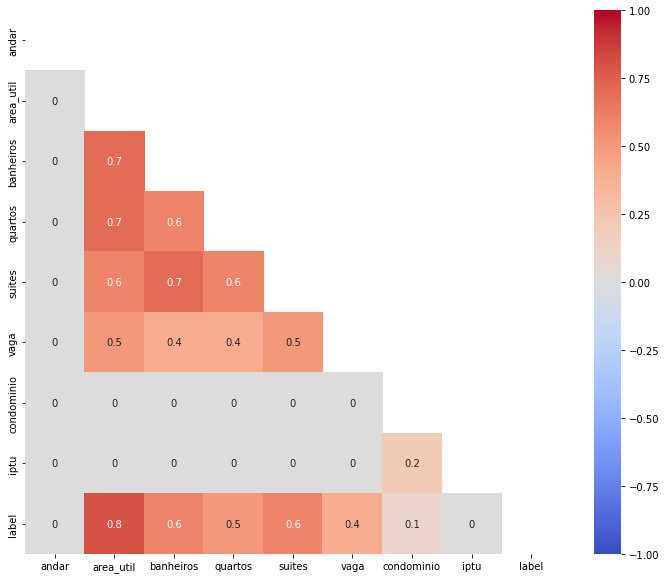

In [69]:
plt.figure(figsize=(12,10))
paleta = sns.color_palette("coolwarm", as_cmap=True)
mask = np.triu(np.ones_like(df_corr, dtype=bool))
sns.heatmap(df_corr.round(1),annot=True,cmap=paleta,vmin=-1,vmax=1,mask=mask)
plt.show()

Maiores correlações entre as variáveis de entrada são positivas (0.7):

- `area_util` e `banheiros`

- `area_util` e `quartos`

- `suites` e `banheiros`

Essas correlações não são altas o suficiente para causarem algum problema. Portanto nenhuma variável precisa ser removida do modelo.

Maior correlação da variável de saída é com a variável `area_util` (0.8). Portanto a variável `area_util` parece ser um bom preditor para o preço do imóvel.

### Separando dataset de treino e de teste

70% dos dados serão utilizados para o treinamento dos modelos e 30% para a avaliação.

In [71]:
treino, teste = dataset_modelo.randomSplit([0.7, 0.3], seed=101)

### Regressão Linear

In [72]:
from pyspark.ml.regression import LinearRegression

In [73]:
lr = LinearRegression()

In [74]:
modelo_lr = lr.fit(treino)

In [75]:
previsoes_lr_treino = modelo_lr.transform(treino)

In [76]:
previsoes_lr_teste = modelo_lr.transform(teste)

In [77]:
from pyspark.ml.evaluation import RegressionEvaluator

In [78]:
evaluator = RegressionEvaluator()

Para avaliar os modelos estão sendo usadas duas métriacas:

- r2 - coeficiente de determinação - informa o quanto o modelo se "encaixa" nos dados ou o quanto da variância dos dados é explicada pelo modelo. Os valores ficam sempre entre zero e um, e quanto mais próximo de um melhor é o modelo. 
- RMSE - Root Mean Square Error - Erro quadratico médio - informa o valor médio do erro do modelo, portanto, quanto menor o valor, melhor é a performance do modeo

In [79]:
print('Linear Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_lr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_lr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_lr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_lr_teste, {evaluator.metricName: "rmse"}))

Linear Regression
Dados de Treino
R²: 0.666697
RMSE: 853352.183180

Dados de Teste
R²: 0.662490
RMSE: 846439.252798


### Decision Tree Regressor

In [80]:
from pyspark.ml.regression import DecisionTreeRegressor

In [81]:
dtr = DecisionTreeRegressor(seed=101)

In [82]:
modelo_dtr = dtr.fit(treino)

In [83]:
previsoes_dtr_treino = modelo_dtr.transform(treino)

In [84]:
previsoes_dtr_teste = modelo_dtr.transform(teste)

In [85]:
print('Decision Tree Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}))

Decision Tree Regression
Dados de Treino
R²: 0.750262
RMSE: 738670.776807

Dados de Teste
R²: 0.722551
RMSE: 767438.558336


### Random Forest Regressor

In [86]:
from pyspark.ml.regression import RandomForestRegressor

In [87]:
rfr = RandomForestRegressor(seed=101)

In [88]:
modelo_rfr = rfr.fit(treino)

In [89]:
previsoes_rfr_treino = modelo_rfr.transform(treino)

In [90]:
previsoes_rfr_teste = modelo_rfr.transform(teste)

In [91]:
print('Random Forest Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Dados de Treino
R²: 0.771887
RMSE: 705965.055447

Dados de Teste
R²: 0.746801
RMSE: 733133.934211


### Gradient Boost Trees Regressor

In [92]:
from pyspark.ml.regression import GBTRegressor

In [93]:
gbt = GBTRegressor(seed=101)

In [94]:
modelo_gbt = gbt.fit(treino)

In [95]:
previsoes_gbt_treino = modelo_gbt.transform(treino)

In [96]:
previsoes_gbt_teste = modelo_gbt.transform(teste)

In [97]:
print('Gradient Boost Trees Regression')
print("="*30)
print("Dados de Treino")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbt_treino, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbt_treino, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Dados de Teste")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "rmse"}))

Gradient Boost Trees Regression
Dados de Treino
R²: 0.828110
RMSE: 612820.658506

Dados de Teste
R²: 0.785253
RMSE: 675174.279123


#### Comparando os resultados dos modelos no dataset de teste

In [99]:
print('-------Modelo-------|---r2---|----rmse----|')
print("="*45)
print(' Linear Regression  | ', round(evaluator.evaluate(previsoes_lr_teste, {evaluator.metricName: "r2"}),2), ' | ',
      round(evaluator.evaluate(previsoes_lr_teste, {evaluator.metricName: "rmse"}),2))
print("="*45)
print('   Decision Tree    | ', round(evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "r2"}),2), ' | ',
      round(evaluator.evaluate(previsoes_dtr_teste, {evaluator.metricName: "rmse"}),2))
print("="*45)
print('   Random Forest    | ', round(evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}),2), ' | ',
      round(evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}),2))
print("="*45)
print('GradientBoost Trees | ', round(evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "r2"}),2), ' | ',
      round(evaluator.evaluate(previsoes_gbt_teste, {evaluator.metricName: "rmse"}),2))
print("="*45)


-------Modelo-------|---r2---|----rmse----|
 Linear Regression  |  0.66  |  846439.25
   Decision Tree    |  0.72  |  767438.56
   Random Forest    |  0.75  |  733133.93
GradientBoost Trees |  0.79  |  675174.28


### Otimizando os hiperparâmetros - Random Forest

Avaliando diferentes valores para alguns hiperparâmetros do modelo Random Forest

In [100]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

`numTrees` -> número de árvores (default = 20)

`masDepth` -> profundidade da árvore. Quantas divisões serão feitas antes de chegar em uma folha (default = 5). 

`maxBins` -> número máximo de divisões (bins) para a discretização de uma variável continua (default = 32)

In [101]:
grid = ParamGridBuilder() \
              .addGrid(rfr.numTrees, [10, 20, 30]) \
              .addGrid(rfr.maxDepth, [5, 10]) \
              .addGrid(rfr.maxBins, [10, 32, 45]) \
              .build()

In [103]:
rfr_cv = CrossValidator(
    estimator=rfr,
    estimatorParamMaps=grid,
    evaluator=evaluator,
    numFolds=3,
    seed=101
)

In [104]:
modelo_rfr_cv = rfr_cv.fit(treino)

In [105]:
best_model = modelo_rfr_cv.bestModel

In [106]:
print('O melhor resultado foi obtido com:\nnumTrees = ', best_model.getNumTrees, '\nmaxDepth = ', best_model.getMaxDepth(),'\nmaxBins = ', best_model.getMaxBins())

O melhor resultado foi obtido com:
numTrees =  30 
maxDepth =  10 
maxBins =  45


In [107]:
previsoes_rfr_cv_teste = modelo_rfr_cv.transform(teste)

In [108]:
print('Random Forest Regression')
print("="*30)
print("Sem Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_teste, {evaluator.metricName: "rmse"}))
print("")
print("="*30)
print("Com Cross Validation")
print("="*30)
print("R²: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "r2"}))
print("RMSE: %f" % evaluator.evaluate(previsoes_rfr_cv_teste, {evaluator.metricName: "rmse"}))

Random Forest Regression
Sem Cross Validation
R²: 0.746801
RMSE: 733133.934211

Com Cross Validation
R²: 0.814759
RMSE: 627077.260228


#### Conclusões

O modelo com o melhor resultado no dataset de teste foi o GBT Regressor, com um r2 de 0.79. 

Porém, otimizando os hiperparâmetros do modelo Random Forest, foi possível obter um r2 ainda melhor de 0.82.